In [ ]:
# Run the code below for setting up google colab enviroment
# # install condacolab
# !pip install -q condacolab
# import condacolab
# condacolab.install()

# # copy from github
# !git clone https://github.com/valence-labs/mtl_summer_school_2024.git

# # change working directory
# import os
# os.chdir("mtl_summer_school_2024/Lab1")

# # install dependencies
# !mamba env update -n base -f env.yml

To successfully apply ML, we need a data set of molecules and bioactivities, a molecular representation, and a ML algorithm to train a model. Then, we can make predictions for new molecules.

In [6]:
%load_ext autoreload
%autoreload 2
    
import pandas as pd
import datamol as dm
import numpy as np


## Load compound and activity data

Let’s start by loading our data. The csv file is loaded into a dataframe with the important columns:

- `MOL_smiles`: SMILES string of the corresponding compound.

- `pIC50`: Measured inhibition affinity. The negative log of the IC50 value.

In [7]:
data = pd.read_csv("data/egfr_pIC50.csv")
mol_col = "MOL_smiles"
data_col = "pIC50"

In [8]:
# Look at head
print("Shape of dataframe : ", data.shape)
data.head()

Shape of dataframe :  (5145, 15)


,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pIC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,InChI,SMILES,updated,MOL_smiles,unique_id
0,AAAAZQPHATYWOK-YRBRRWAQNA-N,CHEMBL175513,1956,A,6.73000,chembl20,312997,9606,EGFR,1260,InChI=1/C32H29ClN6O3S/c1-4-41-28-16-25-22(15-2...,C1=2C(=C(C#N)C=NC1=CC(=C(C2)NC(/C=C/CN(C)C)=O)...,NaN,CCOc1cc2ncc(C#N)c(Nc3ccc(OCc4nc5ccccc5s4)c(Cl)...,e20a75a5e83123c7b26f8eb4cda6315611bda442
1,AAALVYBICLMAMA-MPIMZMORNA-N,CHEMBL268868,1956,A,6.80000,chembl20,29499,9606,EGFR,1260,InChI=1/C20H15N3O2/c24-19-15-11-17(21-13-7-3-1...,C=1C=C(NC2=C(NC3=CC=CC=C3)C=C4C(NC(C4=C2)=O)=O...,NaN,O=C1NC(=O)c2cc(Nc3ccccc3)c(Nc3ccccc3)cc21,6cd7ab48e50c5e2f499850b11b4e9765b80f28f4
2,AABTVDZTFBSBKN-UHFFFAOYNA-N,44416433,1956,A,5.92082,pubchem,271215,9606,EGFR,1260,InChI=1/C20H18BrN3O4/c1-24-10-12-7-16(25-2)17(...,BrC=1C=C(OC2=NC=NC=3OC=4C(CN(C32)C)=CC(OC)=C(O...,NaN,COc1cc2c(cc1OC)Oc1ncnc(Oc3cccc(Br)c3)c1N(C)C2,4cdd2dd38339366c66c2fba69fc26debf6558221
3,AAGKMGNYUYCEPD-HIVOMVAKNA-N,CHEMBL2048906,1956,A,8.54000,chembl20,827250,9606,EGFR,1260,InChI=1/C23H19ClN6O2S/c1-14(31)25-8-10-30-9-7-...,C(C)(=O)NCCN1C=CC2=NC=NC(=C21)NC=3C=C(C(=CC3)O...,NaN,CC(=O)NCCn1ccc2ncnc(Nc3ccc(Oc4cccc5sncc45)c(Cl...,1c08521ee2742402d71148c520ff92857f606ce1
4,AAHKGRWRYBCWDL-HPHMPNDVNA-N,CHEMBL1240554,1956,A,5.85000,chembl20,654933,9606,EGFR,1260,InChI=1/C19H23N5O2/c1-3-26-14-9-8-12(10-15(14)...,N1=CN=C2N(N=C(C=3C=CC(=C(OC)C3)OCC)C2=C1N)C4CCCC4,NaN,CCOc1ccc(-c2nn(C3CCCC3)c3ncnc(N)c23)cc1OC,a02a3767c7bcce175a3b3fbdc25aee464aacdf20


<Axes: >

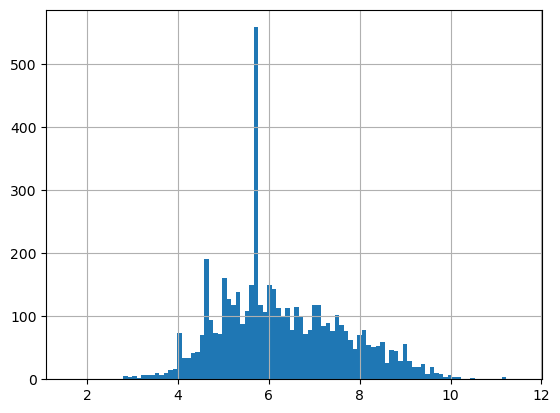

In [9]:
data[data_col].hist(bins=100)

## For ML, molecules need to be converted into a list of features/representation.

In this tutorial, we will focus on **Fingerprint** and **Molecular Graph**.

### Morgan fingerprints ECFP
Extended-Connectivity Fingerprints (ECFPs) are circular topological fingerprints designed for molecular characterization, similarity searching, and structure-activity modeling. We use the implementation from RDKit which is called Morgan fingerprint.

The two most important parameters of these fingerprints are the `radius` and `fingerprint length`. The first specifies the radius of circular neighborhoods considered for each atom. Here two radis are considered: 2 and 3. The length parameter specifies the length to which the bit string representation is hashed. The default length is 2048.

 This implementation is avalaible in [molfeat](https://molfeat.datamol.io/), which is a hub for all molecular featurizers.

In [10]:
from molfeat.trans.fp import FPVecTransformer

fp_transformer = FPVecTransformer(kind='ecfp:4', length=2048)
features =fp_transformer(data[mol_col].values)

# or use `datamol.to_fp`
# features =np.stack(dm.parallelized(fn=dm.to_fp, inputs_list=egfr[mol_col].values, progress=True))

activities = data[data_col].values

/Users/lu.zhu/miniconda3/envs/vs/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[22:36:09] DEPRECATION WARNING: please use MorganGenerator
[22:36:09] DEPRECATION WARNING: please use MorganGenerator
[22:36:09] DEPRECATION WARNING: please use MorganGenerator
[22:36:09] DEPRECATION WARNING: please use MorganGenerator
[22:36:09] DEPRECATION WARNING: please use MorganGenerator
[22:36:09] DEPRECATION WARNING: please use MorganGenerator
[22:36:09] DEPRECATION WARNING: please use MorganGenerator
[22:36:09] DEPRECATION WARNING: please use MorganGenerator
[22:36:09] DEPRECATION WARNING: please use MorganGenerator
[22:36:09] DEPRECATION WARNING: please use MorganGenerator
[22:36:09] DEPRECATION WARNING: please use MorganGenerator
[22:36:09] DEPRECATION WARNING: please use MorganGenerator
[22:36:09] DEPRECATION WA

Use those molecular fingerprints as features as the inputs for ML model.

<img src="figures/fp_ml.png" width="300"/>

In [94]:
# Exercise 1: Custom featurization
# How to best featurize a molecule depends on the task you're trying to solve. 
# In this example, we used ECFP. Datamol.io `molfeat` offers a range of other featurization schemes that
# may perform better. Try out a few different options by overwriting the X variable.

# === YOUR CODE GOES HERE ===

# === END ===

###  Molecular graph

<img src="figures/graph.png" width="500"/>

In [11]:
### Process smiles into `torch_geometric.Data` objects
from molfeat.trans.graph.adj import PYGGraphTransformer

# convert smiles to Rdkit.Mol object
mols = dm.parallelized(fn=dm.to_mol, inputs_list=data[mol_col], progress=True)

# conver Rdkit.Mol object to `torch_geometric.Data` object
transformer = PYGGraphTransformer()
pyg_features = transformer(mols)

100%|█████████████████████████████████████| 5145/5145 [00:01<00:00, 2887.38it/s]


In [12]:
#### Molecular graph example
pyg_mol = pyg_features[0]
pyg_mol

Data(x=[43, 82], edge_index=[2, 94])

In [13]:
# Visualize the adjacent matrix of the graph
from torch_geometric.utils import to_dense_adj

# convert the graph object to adjacent matrix for visualization
to_dense_adj(pyg_mol.edge_index)

tensor([[[0., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 1., 1.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.]]])

We can use pyg graph object as input for GNN modeling for inhibition prediction.

## Model training

The goal is to test the ability of the model to predict data which it has never seen before in order to flag problems known as over fitting and to assess the generalization ability of the model.

We start by defining a function model_performance which evaluate a model on a **random train-test split** of the data and returns measures such as `mean_squared_error`, `pearsonr`and `spearmanr` evaluated on the heldout test set. We also plot the scatter plot of the true bioactivity and predictions with a linear regression model fit.

In [14]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from scipy import stats
import torch
from loguru import logger
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor

In [15]:

def pearsonr(y_true: np.ndarray, y_pred: np.ndarray):
    """Calculate a pearson r correlation"""
    return stats.pearsonr(y_true, y_pred).statistic


def spearman(y_true: np.ndarray, y_pred: np.ndarray):
    """Calculate a Spearman correlation"""
    return stats.spearmanr(y_true, y_pred).statistic


def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Args
    ----------
    ml_model: model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        MSE, Pearson R, Spearman on test set.
    """

    # Prediction class on test 
    if isinstance(ml_model, RandomForestRegressor):
        test_pred = ml_model.predict(test_x)
    else:
        model.eval() #set model to evaluate mode
        test_pred = torch.cat([ml_model.predict(x) for x in test_x]).numpy().flatten()

    # Performance of model on test set
    mse = mean_squared_error(test_y, test_pred)

    pearsonr_score = pearsonr(test_y, test_pred)
    
    spearman_score = spearman(test_y, test_pred)


    if verbose:
        # Print performance results
        logger.info(f"mean_squared_error: {mse:.2f}")
        logger.info(f"pearson r: {pearsonr_score:.2f}")
        logger.info(f"spearman: {spearman_score:.2f}")

    plot_df = pd.DataFrame({"y_true": test_y, "y_pred": test_pred})
    sns.set_style("whitegrid")
    fig = sns.regplot(data=plot_df, x="y_true", y="y_pred")
    
    return mse, pearsonr_score, spearman_score, fig


#### Data splitting for hit identification
Distribution in the chemical space 

<img src="figures/chemspace.png" width="800"/>

Let's create split data into train and test set. The splits will be shared with all the models. 

In [16]:
from splito._scaffold_split import ScaffoldSplit

spliter = ScaffoldSplit(smiles=data[mol_col].values, n_splits=5, test_size=.2, random_state=111)
train_index, test_index = next(spliter.split(activities))

print("Training data size:", len(train_index))
print("Test data size:", len(test_index))

Training data size: 3784
Test data size: 1361


In [95]:
# Exercise 2: Choice of splitting method
# We have 
# In this example, we used scaffold based spliting approach. Datamol.io `splito` offers a range of other splitting method schemes that
# may suit the project purpose better. Try out a few different options and observe the impact on model performance.

# === YOUR CODE GOES HERE ===

# === END ===

#### Random forest regressor

In [17]:
# Get the features and bioactivities of the training set
train_x, train_y = features[train_index], activities[train_index]

print("Training set data shape:", train_x.shape)

Training set data shape: (3784, 2048)


In [18]:
# Define a model and train
from sklearn.ensemble import RandomForestRegressor

# Set model parameter for random forest
rf_param = {
    "n_estimators": 100,  # number of trees to grows
    "criterion": "squared_error",  # cost function to be optimized for a split
}

RF_model = RandomForestRegressor(**rf_param)

In [19]:
# Fit model on single train split
RF_model.fit(train_x, train_y)

RandomForestRegressor()

2024-06-09 22:36:38.435 | INFO     | __main__:model_performance:49 - mean_squared_error: 0.96
2024-06-09 22:36:38.436 | INFO     | __main__:model_performance:50 - pearson r: 0.76
2024-06-09 22:36:38.436 | INFO     | __main__:model_performance:51 - spearman: 0.77


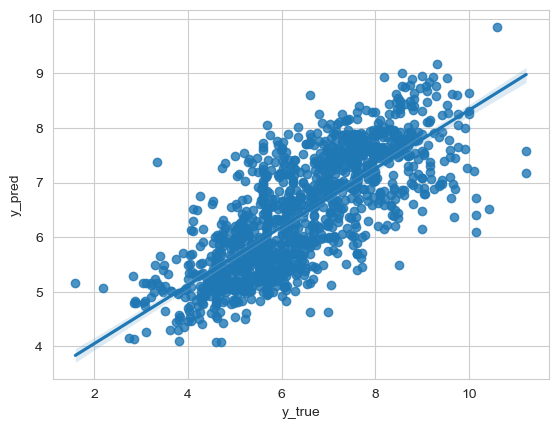

In [20]:
# Get the features and bioactivities of the test set
test_x, test_y = features[test_index], activities[test_index]

# Compute the performance and generate the plot
res = model_performance(RF_model, test_x, test_y, verbose=True)

In [ ]:
# Dump the transformer and model to pickle file
import pickle

with open("model/rf_regressor.pkl", "wb") as fout:
    pickle.dump((fp_transformer, RF_model), fout)

#### Cross validation

In [87]:
from sklearn import clone
def crossvalidation(ml_model, spliter, features, activities, n_folds=5, verbose=True):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    # Results for each of the cross-validation folds
    pearsonr_per_fold = []
    spearman_per_fold = []
    mse_per_fold = []

    spliter = ScaffoldSplit(smiles=data[mol_col].values, n_splits=5, test_size=.2, random_state=111)
    # Loop over the folds
    for train_index, test_index in spliter.split(activities):

        # clone the newly initiated model
        fold_model = clone(ml_model)
        
        # Training

        # Convert the fingerprint and the label to a list
        train_x = features[train_index]
        train_y = activities[train_index]

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = features[test_index]
        test_y = activities[test_index]

        # Performance for each fold
        mse, pearsonr_score, spearman_score, _ = model_performance(fold_model, test_x, test_y, verbose)

        # Save results
        mse_per_fold.append(mse)
        pearsonr_per_fold.append(pearsonr_score)
        spearman_per_fold.append(spearman_score)
        
    # Print statistics of results
    print(
        f"Mean accuracy: {np.mean(mse_per_fold):.2f} \t"
        f"and std : {np.std(mse_per_fold):.2f} \n"
        f"Mean sensitivity: {np.mean(pearsonr_per_fold):.2f} \t"
        f"and std : {np.std(pearsonr_per_fold):.2f} \n"
        f"Mean specificity: {np.mean(spearman_per_fold):.2f} \t"
        f"and std : {np.std(spearman_per_fold):.2f} \n"
    )

    return mse_per_fold, pearsonr_per_fold, spearman_per_fold

2024-06-09 23:08:21.147 | INFO     | __main__:model_performance:49 - mean_squared_error: 0.96
2024-06-09 23:08:21.148 | INFO     | __main__:model_performance:50 - pearson r: 0.76
2024-06-09 23:08:21.148 | INFO     | __main__:model_performance:51 - spearman: 0.77
2024-06-09 23:08:42.855 | INFO     | __main__:model_performance:49 - mean_squared_error: 0.76
2024-06-09 23:08:42.856 | INFO     | __main__:model_performance:50 - pearson r: 0.79
2024-06-09 23:08:42.856 | INFO     | __main__:model_performance:51 - spearman: 0.78
2024-06-09 23:09:04.851 | INFO     | __main__:model_performance:49 - mean_squared_error: 0.74
2024-06-09 23:09:04.851 | INFO     | __main__:model_performance:50 - pearson r: 0.81
2024-06-09 23:09:04.852 | INFO     | __main__:model_performance:51 - spearman: 0.79
2024-06-09 23:09:26.212 | INFO     | __main__:model_performance:49 - mean_squared_error: 0.76
2024-06-09 23:09:26.213 | INFO     | __main__:model_performance:50 - pearson r: 0.81
2024-06-09 23:09:26.213 | INFO  

Mean accuracy: 0.77 	and std : 0.12 
Mean sensitivity: 0.79 	and std : 0.02 
Mean specificity: 0.77 	and std : 0.02 



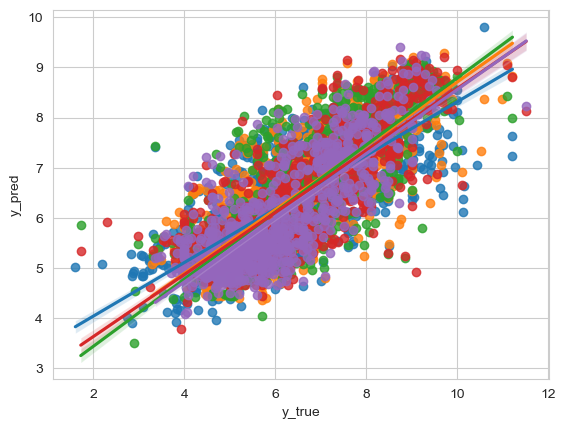

In [88]:
mse_per_fold, personr_per_fold, spearman_per_fold = crossvalidation(ml_model=RandomForestRegressor(**rf_param), 
                                                                    spliter=spliter,
                                                                    features=features, activities=activities)

#### Graph neural network
Here we try to train a graph neural network model with 3 convolutional layers and a followed by a linear transformer for final output.

In [90]:
import torch
from gnn import GCNModel

# Define the graph model
# Use CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

# Create network and send to the device memory
gnn_model = GCNModel(in_channels=transformer(mols[0])[0].x.shape[1], 
                     hidden_channels=128, 
                     out_channels=1, 
                     num_layers=3,
                     is_reg=True).to(device)

# Use Adam optimizer
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001, weight_decay=1e-4) 


# Define the loss function
loss_fn = torch.nn.MSELoss()

In [91]:
# Display the GNN model
gnn_model

GCNModel(
  (conv_layers): ModuleList(
    (0): GCNConv(82, 128)
    (1-3): 3 x GCNConv(128, 128)
  )
  (out): Linear(in_features=256, out_features=1, bias=True)
)

Below we convert the smiles to pyg graph object directly using `PYGGraphTransformer` from `molfeat`.

Each graph in our dataset is encapsulated in a PyG Data object, a convient way of representing all structured data for use in Geometric Deep Learning (including graphs, point clouds, and meshes).

In [92]:
from molfeat.trans.graph.adj import PYGGraphTransformer

# convert smiles to Rdkit.Mol object
mols = np.array(dm.parallelized(fn=dm.to_mol, inputs_list=data[mol_col], progress=True))

# converT Rdkit.Mol object to `torch_geometric.Data` object
transformer = PYGGraphTransformer()

train_set = []
for index in train_index:
    pyg_data = transformer(mols[index])[0]
    pyg_data.y =torch.from_numpy(np.array([activities[index]])).to(torch.float32)
    train_set.append(pyg_data)

test_set = []
for index in test_index:
    pyg_data = transformer(mols[index])[0]
    pyg_data.y =torch.from_numpy(np.array([activities[index]])).to(torch.float32)
    test_set.append(pyg_data)

100%|█████████████████████████████████████| 5145/5145 [00:01<00:00, 2825.10it/s]


Batching graphs can often be a tedious and intricate process. Fortunately, PyG simplifies this task significantly! With a list of Data objects, we can effortlessly batch them into a PyG Batch object and also unbatch them back into individual graphs. Moreover, for straightforward scenarios like ours, the PyG DataLoader object takes care of all the batching automatically.

In [93]:
# Create dataloaders with batch size 8
from torch_geometric.loader import DataLoader

batch_size = 16

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [ ]:
from tqdm import tqdm
num_epoch = 10

#train model
#set model to training mode
gnn_model.train() 

#run for epochs of training
for epoch in range(num_epoch): 
    sum_loss = 0 #used to compute average loss in an epoch

    #go over each training batches
    for batch in tqdm(train_set): 
        batch = batch.to(device) #send data to device
        optimizer.zero_grad() #zero gradients
        
        # #evaluate data point
        out = gnn_model(batch)
        loss = loss_fn(out, batch.y) #compute the loss
        sum_loss += float(loss) # Add loss value to aggregate loss
        
        #compute gradients
        loss.backward()
        #apply optimization
        
        optimizer.step()
    logger.info('Epoch: {:03d}, Average loss: {:.5f}'.format(epoch, sum_loss/len(train_set)))


  0%|                                                  | 0/3784 [00:00<?, ?it/s]

In [ ]:
# Compute the performance and generate the plot

res = model_performance(gnn_model, test_loader, test_y, verbose=True)

#### Save both molecular transformer and the model 

In [ ]:
import pickle
with open("model/gnn_regressor.pkl", "wb") as fout:
    pickle.dump((transformer, gnn_model), fout)

In [97]:
# Exercise 3: Graph representation learning with graphium

# Instead of `pyg`, try use Datamol.io `graphium` to train graph-based model. 
# Tutorials are available at https://graphium-docs.datamol.io/stable/tutorials

# === YOUR CODE GOES HERE ===

# === END ===

#### Hyperparameter tuning

Hyperparameter tuning is the process of selecting the best set of parameters for a machine learning model and the dataset to improve the performance.

One can perform efficient HP tuning by using frameworks, such as Optuna and Weights & Biases sweep.

<img src="figures/HP_tuning.png" width="800"/>